## Tensorboard

In [1]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
! del /q %TMP%\.tensorboard-info\*

The system cannot find the file specified.


In [2]:
%tensorboard --logdir logs/scalars --host localhost

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy import ndimage, misc

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
from skimage.transform import resize
import pylab
import pydicom as pyd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image

import cv2

Using TensorFlow backend.


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("physical_devices-------------", len(physical_devices))
# tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def dcmchange(orig,clahe,mask) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = mask[:,:]
    return new

In [4]:
from skimage import measure, morphology, segmentation
from skimage import exposure
def marker(img):
    h,w = img.shape[:2]
    for row in range(h):
        if img[row, 0] == 1:
            cv2.floodFill(img, None, (0, row), 0)
        if img[row, w-1] == 1:
            cv2.floodFill(img, None, (w-1, row), 0)
    for col in range(w):
        if img[0, col] == 1:
            cv2.floodFill(img, None, (col, 0), 0)
        if img[h-1, col] == 1:
            cv2.floodFill(img, None, (col, h-1), 0)
    holes = img.copy()
    cv2.floodFill(holes, None, (0,0), 1)
    holes = cv2.bitwise_not(holes)
    mask = cv2.bitwise_or(img, holes)
    mask_img = cv2.bitwise_and(img, img, mask=mask)
    return mask_img

## Read Data

In [5]:
p = Path("./dataset/Intras/")
dirs = p.glob("*")
labels_dict = {'fold1':0, 'fold2':1, 'fold3':2,
               'fold4': 3, 'fold5': 4, 'test': 5, 'No Finding' : 6}
count = 0

fold1_images = []
fold2_images = []
fold3_images = []
fold4_images = []
fold5_images = []
test_images = []

count_fold1 = 0
count_fold2 = 0
count_fold3 = 0
count_fold4 = 0
count_fold5 = 0
count_test = 0

for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'fold1' or label == 'fold2' or label == 'fold3' or label == 'fold4' or label == 'fold5' or label == 'test' :
        for img_path in folder_dir.glob("*.dcm"):
        #             print(img_path)
        #             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)

            pic = pyd.read_file(target)
            pic_r = np.array(pic.pixel_array)
            %matplotlib inline 
            #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
            #         preprocessing
            IMG_PX_SIZE = 224
            resized_img1 = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_img1, clip_limit=0.03)
                    #change pic to (224,224,3)
            resized_img2 = dcmchange(resized_img1,resized_clahe,resized_equal)
            resized_img = exposure.equalize_adapthist(resized_img2, clip_limit=0.03)
            
            if label == 'fold1' :
                fold1_images.append(resized_img)
                count_fold1+=1
            elif label == 'fold2' :
                fold2_images.append(resized_img)
#                 fold2_labels.append(labels_dict[label])
            #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_fold2+=1
            elif label == 'fold3' :
                fold3_images.append(resized_img)
#                 fold3_labels.append(labels_dict[label])
            #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_fold3+=1
            elif label == 'fold4' :
                fold4_images.append(resized_img)
#                 fold4_labels.append(labels_dict[label])
            #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_fold4+=1
            elif label == 'fold5' :
                fold5_images.append(resized_img)
#                 fold5_labels.append(labels_dict[label])
            #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_fold5+=1
            elif label == 'test' :
                test_images.append(resized_img)
#                 test_labels.append(labels_dict[label])
            #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_test+=1

            if count_fold1 == 150 or count_fold2 == 150 or count_fold3 == 150 or count_fold4 == 150 or count_fold5 == 150 or count_test == 250 : 
                break
        count_fold1 = 0
        count_fold2 = 0
        count_fold3 = 0
        count_fold4 = 0
        count_fold5= 0
        count_test = 0

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


In [6]:
p = Path("./dataset/")
dirs = p.glob("*")
labels_dict = {'Abnormal':0, 'Extra':1, 'Heart and TGV':0,
               'Intra': 3, 'No Finding': 1, 'TB': 5, 'Pneumonia' : 6}
count = 0

normal_images = []
# normal_labels = []

count_normal = 0


for folder_dir in dirs:
    label = str(folder_dir).split("/")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)

            pic = pyd.read_file(target)
            pic_r = np.array(pic.pixel_array)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_img1 = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_img1, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img2 = dcmchange(resized_img1,resized_clahe,resized_equal)
            resized_img = exposure.equalize_adapthist(resized_img2, clip_limit=0.03)
    #         resized_img = resized_img.flatten()
            if label == 'No Finding' :
                normal_images.append(resized_img)
#                 normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 1000: 
                break

        count_normal = 0


/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:265: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v


## Test/Train

In [7]:
# normal_labels = np.array(normal_labels)
normal_images = np.array(normal_images, dtype=np.float32)
# fold1_labels = np.array(fold1_labels)
fold1_images = np.array(fold1_images, dtype=np.float32)
# fold2_labels = np.array(fold2_labels)
fold2_images = np.array(fold2_images, dtype=np.float32)
# fold3_labels = np.array(fold3_labels)
fold3_images = np.array(fold3_images, dtype=np.float32)
# fold4_labels = np.array(fold4_labels)
fold4_images = np.array(fold4_images, dtype=np.float32)
# fold5_labels = np.array(fold5_labels)
fold5_images = np.array(fold5_images, dtype=np.float32)
# test_labels = np.array(test_labels)
test_images = np.array(test_images, dtype=np.float32)

In [8]:
# print("number of sample No Finding: {}".format(len(normal_images)))
print("number of sample fold1: {}".format(len(fold1_images)))
print("number of sample fold2: {}".format(len(fold2_images)))
print("number of sample fold3: {}".format(len(fold3_images)))
print("number of sample fold4: {}".format(len(fold4_images)))
print("number of sample fold5: {}".format(len(fold5_images)))
print("number of sample test: {}".format(len(test_images)))
print("number of sample test: {}".format(len(normal_images)))

number of sample fold1: 150
number of sample fold2: 150
number of sample fold3: 150
number of sample fold4: 150
number of sample fold5: 150
number of sample test: 250
number of sample test: 1000


In [6]:
test_images[1].shape

(224, 224, 3)

In [21]:
np.max(fold1_images[100])

1.0

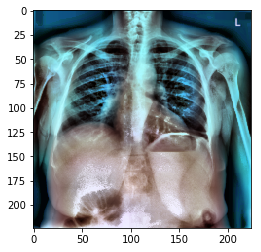

In [22]:
plt.imshow(fold1_images[1])

## Feature

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

# from tensorflow.keras.applications import VGG16

## Model

In [10]:
def cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 2e-3
    EPOCHS = 60
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg_model = VGG16(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg_model.layers:
        layer.trainable = False
        
    new_model = vgg_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(1024, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='categorical_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=128,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     y_roc = model.predict(X_val)
#     y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = history.predict_proba(X_val)[:, 1]
#     print(y_score)

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model/intra/vgg16/'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [11]:
from tensorflow.keras.applications import VGG19
def vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 5e-3
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
    vgg19_model = VGG19(weights="imagenet", 
                             include_top= False,
                             input_tensor=Input(shape=(224, 224,3)))
    
    for layer in vgg19_model.layers:
        layer.trainable = False
        
    new_model = vgg19_model.output
    new_model = AveragePooling2D(pool_size=(7, 7))(new_model)
    new_model = Flatten(name="flatten")(new_model)
    new_model = Dense(64, activation="relu")(new_model)
    new_model = Dropout(0.4)(new_model)
    new_model = Dense(2, activation="softmax")(new_model)
    model = Model(inputs=vgg19_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='binary_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=256,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_val)
#     y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    #confusion
    confusion(y_val,y_pred)
#     y_score = history.predict(X_test)
#     y_score = model.predict_proba(X_test)[:, 1] 

    #roc
    fpr, tpr, thresholds = roc_curve(y_val[:,1], y_pred[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    
    #save model
    model.save('model/intra/vgg19/'+str(text)+'_'+str(r))
    
    return fpr,tpr,roc_auc

In [12]:
from tensorflow.keras.applications import InceptionV3
def inv3_model(X_train,y_train,X_test,y_test,X_val,y_val,r,text) :
    
    tf.keras.backend.clear_session()
    
    #tensorboard
    logdir = "logs\\scalars\\" + str(text) + "-Fold" + str(r) + "-" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    
    INIT_LR = 1e-2
    EPOCHS = 20
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    
#     incepv3_model = InceptionV3(weights="imagenet", 
#                              include_top= False,
#                              input_tensor=Input(shape=(224, 224,3)))
    base_model = InceptionV3(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(2, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
#     for layer in incepv3_model.layers:
#         layer.trainable = False
        
#     new_model = incepv3_model.output
#     new_model = GlobalAveragePooling2D()(new_model)
#     new_model = Flatten(name="flatten")(new_model)
#     new_model = Dropout(0.4)(new_model)
#     new_model = Dense(128, activation="relu")(new_model)
#     new_model = Dense(2, activation="softmax")(new_model)
#     model = Model(inputs=incepv3_model.input, outputs=new_model)
    
#     model.summary()

    model.compile(optimizer=opt,
#               loss='categorical_crossentropy',
                loss='categorical_crossentropy',
              metrics=['accuracy'])
#     with tf.device("/device:GPU:0"):
    history = model.fit(
        X_train, # input
        y_train, # output
        batch_size=128,
        verbose=0, # Suppress chatty output; use Tensorboard instead
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
#         callbacks=[tensorboard_callback],
    )
    print("Average test accuracy: ", np.average(history.history['accuracy']))
    print("Average test loss: ", np.average(history.history['loss']))
    
    %matplotlib inline 
    
    plt.figure()
    plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
    plt.plot(history.history['loss'], 'red', label='Training loss')
    plt.plot(history.history['val_loss'], 'green', label='Validation loss')
    plt.legend()
    plt.show()
    
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred,axis = 1)
#     print(y_pred)
    #confusion
    confusion(y_test,y_pred)
#     y_score = history.predict(X_test)
#     y_score = model.predict_proba(X_test)[:, 1]    
    return y_pred

## Confusion Matrix

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report 
def confusion(y_test,pred) :
    cm_plot_labels = ['Finding', 'Normal']
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test.argmax(axis=1), pred.argmax(axis=1))
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
#     plot_confusion_matrix(confusion_mat1, cm_plot_labels, title='Confusion Matrix')
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")
    plt.show()
    
    print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=cm_plot_labels))
    

## ROC

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [15]:
def roc(fpr_recv,tpr_recv,acc_recv,num) :

    color = ["orange","green","blue","red","purple"]
    for i in range(num):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         print(len(fpr_use))
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    std_auc = np.std(acc_recv)
    tprs = []
#     auc = []
    mean_fpr = np.linspace(0, 1, 100)
    for i in range(num):
        tprs.append(np.interp(mean_fpr, fpr_recv[i], tpr_recv[i]))
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    print(type(mean_fpr))
    print(type(mean_tpr))
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, color='black', 
             label='AUC Fold Average: %0.4f $\pm$ %0.2f' %(mean_auc, std_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

## Run

## Increase

In [16]:
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        new_data.append(data[i])
        new_data.append(ndimage.rotate(data[i], 15, reshape=False))
        new_data.append(ndimage.rotate(data[i], -15, reshape=False))
        new_data.append(cv2.flip(data[i], 1))
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## Abnormal

In [17]:
from sklearn.model_selection import KFold
def newdata(fold_1,fold_2,fold_3,fold_4,fold_5,test_dis,normal,text):
    box_fpr = []
    box_tpr = []
    box_acc = []
    size = fold_1.shape[0]
    X_test = []
    y_test = []
    for i in range(250):
        X_test.append(test_dis[i])
        y_test.append(0)
    for j in range(250):
        X_test.append(normal[j])
        y_test.append(1)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    n_classes = 2
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    data = []
    label =[]
    train_normal = []
    index = 250
    for k in range(5*size):
        if k < size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_1[k])
            label.append(0)
        elif k < 2 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_2[k-size])
            label.append(0)
        elif k < 3 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_3[k-(2 * size)])
            label.append(0)
        elif k < 4 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_4[k-(3 * size)])
            label.append(0)
        elif k < 5 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_5[k-(4 * size)])
            label.append(0)
    
    label = np.array(label)
#     print(label.shape)
    data = np.array(data, dtype=np.float32)
#     print(data.shape)
    #KFOLD
    cycle = 0
    kf = KFold(5, shuffle=True)
    for train, val in kf.split(data):
        X_train = data[train]
        X_val = data[val]
        y_train = label[train]
        y_val = label[val]
        
#         X_train_n, y_train_n = incre(X_train,y_train)
#         X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_val = keras.utils.to_categorical(y_val, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        print(X_train.shape)
        print(X_test.shape)
        print(X_val.shape)       
        
        recv_fpr,recv_tpr,recv_acc = vgg19_model(X_train,y_train,X_test,y_test,X_val,y_val,cycle,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        cycle += 1
        
        #only one round
#         if cycle == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,cycle)

number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
(1200, 224, 224, 3)
(500, 224, 224, 3)
(300, 224, 224, 3)
Average test accuracy:  0.5832499
Average test loss:  0.6902204378445943


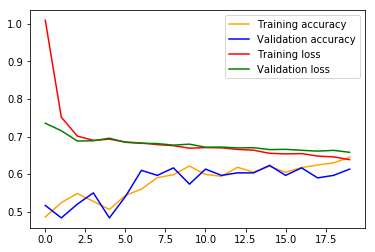

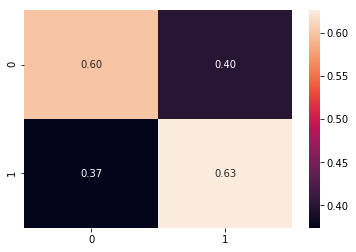

             precision    recall  f1-score   support

    Finding       0.60      0.60      0.60       145
     Normal       0.63      0.63      0.63       155

avg / total       0.61      0.61      0.61       300

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/intra/vgg19/Intra_749/assets
number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
(1200, 224, 224, 3)
(500, 224, 224, 3)
(300, 224, 224, 3)


KeyboardInterrupt: 

In [27]:
newdata(fold1_images,fold2_images,fold3_images,fold4_images,fold5_images,test_images,normal_images,"Intra")

In [18]:
from sklearn.model_selection import KFold
def vgg16(fold_1,fold_2,fold_3,fold_4,fold_5,test_dis,normal,text):
    box_fpr = []
    box_tpr = []
    box_acc = []
    size = fold_1.shape[0]
    X_test = []
    y_test = []
    for i in range(250):
        X_test.append(test_dis[i])
        y_test.append(0)
    for j in range(250):
        X_test.append(normal[j])
        y_test.append(1)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    n_classes = 2
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    data = []
    label =[]
    train_normal = []
    index = 250
    for k in range(5*size):
        if k < size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_1[k])
            label.append(0)
        elif k < 2 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_2[k-size])
            label.append(0)
        elif k < 3 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_3[k-(2 * size)])
            label.append(0)
        elif k < 4 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_4[k-(3 * size)])
            label.append(0)
        elif k < 5 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_5[k-(4 * size)])
            label.append(0)
    
    label = np.array(label)
#     print(label.shape)
    data = np.array(data, dtype=np.float32)
#     print(data.shape)
    #KFOLD
    cycle = 0
    kf = KFold(5, shuffle=True)
    for train, val in kf.split(data):
        X_train = data[train]
        X_val = data[val]
        y_train = label[train]
        y_val = label[val]
        
#         X_train_n, y_train_n = incre(X_train,y_train)
#         X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_val = keras.utils.to_categorical(y_val, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
#         print(X_train.shape)
#         print(X_test.shape)
#         print(X_val.shape)       
        
        recv_fpr,recv_tpr,recv_acc = cnn_model(X_train,y_train,X_test,y_test,X_val,y_val,cycle,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        cycle += 1
        
        #only one round
#         if cycle == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,cycle)

number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
Average test accuracy:  0.66715276
Average test loss:  0.6101263243953386


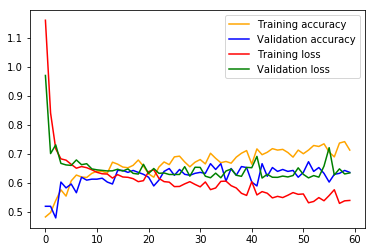

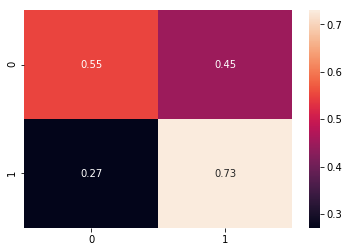

             precision    recall  f1-score   support

    Finding       0.69      0.55      0.61       156
     Normal       0.60      0.73      0.66       144

avg / total       0.65      0.64      0.63       300

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/intra/vgg16/Intra_0/assets
number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
Average test accuracy:  0.6757639
Average test loss:  0.5907685646547212


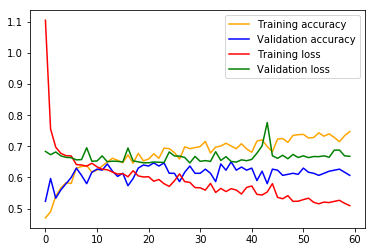

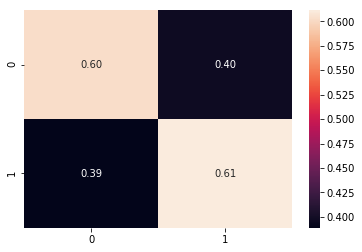

             precision    recall  f1-score   support

    Finding       0.63      0.60      0.61       156
     Normal       0.59      0.61      0.60       144

avg / total       0.61      0.61      0.61       300

INFO:tensorflow:Assets written to: model/intra/vgg16/Intra_1/assets
number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
Average test accuracy:  0.6718473
Average test loss:  0.5992198504010837


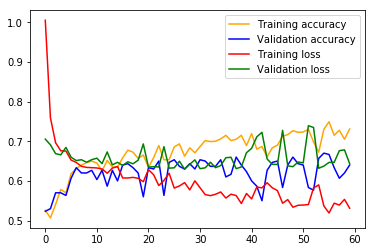

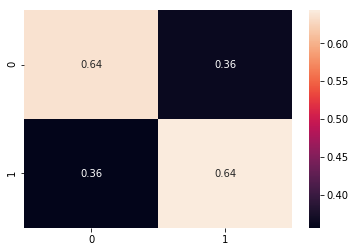

             precision    recall  f1-score   support

    Finding       0.62      0.64      0.63       143
     Normal       0.66      0.64      0.65       157

avg / total       0.64      0.64      0.64       300

INFO:tensorflow:Assets written to: model/intra/vgg16/Intra_2/assets
number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
Average test accuracy:  0.6667917
Average test loss:  0.6046927114592658


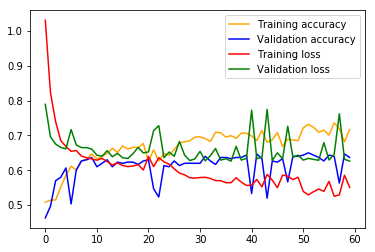

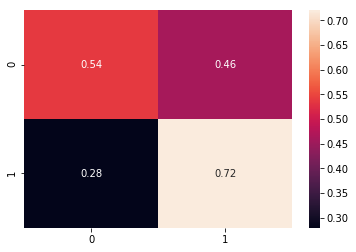

             precision    recall  f1-score   support

    Finding       0.62      0.54      0.58       139
     Normal       0.64      0.72      0.68       161

avg / total       0.64      0.64      0.63       300

INFO:tensorflow:Assets written to: model/intra/vgg16/Intra_3/assets
number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
Average test accuracy:  0.6716805
Average test loss:  0.6011224224037595


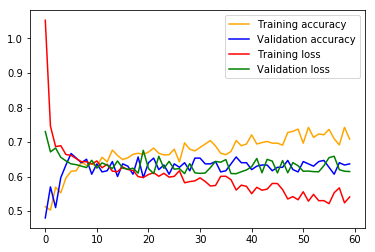

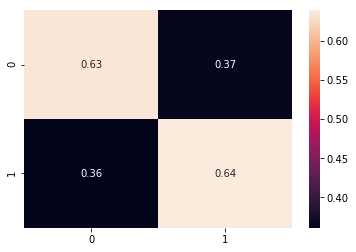

             precision    recall  f1-score   support

    Finding       0.66      0.63      0.64       156
     Normal       0.62      0.64      0.63       144

avg / total       0.64      0.64      0.64       300

INFO:tensorflow:Assets written to: model/intra/vgg16/Intra_4/assets


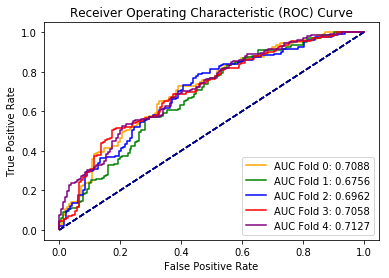

In [19]:
vgg16(fold1_images,fold2_images,fold3_images,fold4_images,fold5_images,test_images,normal_images,"Intra")

## InceptionV3

In [17]:
from sklearn.model_selection import KFold
def incepv3(fold_1,fold_2,fold_3,fold_4,fold_5,test_dis,normal,text):
    box_fpr = []
    box_tpr = []
    box_acc = []
    size = fold_1.shape[0]
    X_test = []
    y_test = []
    for i in range(250):
        X_test.append(test_dis[i])
        y_test.append(0)
    for j in range(250):
        X_test.append(normal[j])
        y_test.append(1)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    n_classes = 2
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    data = []
    label =[]
    train_normal = []
    index = 250
    for k in range(5*size):
        if k < size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_1[k])
            label.append(0)
        elif k < 2 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_2[k-size])
            label.append(0)
        elif k < 3 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_3[k-(2 * size)])
            label.append(0)
        elif k < 4 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_4[k-(3 * size)])
            label.append(0)
        elif k < 5 * size :
            data.append(normal[index+k])
            label.append(1)
            data.append(fold_5[k-(4 * size)])
            label.append(0)
    
    label = np.array(label)
#     print(label.shape)
    data = np.array(data, dtype=np.float32)
#     print(data.shape)
    #KFOLD
    cycle = 0
    kf = KFold(5, shuffle=True)
    for train, val in kf.split(data):
        X_train = data[train]
        X_val = data[val]
        y_train = label[train]
        y_val = label[val]
        
#         X_train_n, y_train_n = incre(X_train,y_train)
#         X_val_n, y_val_n = incre(X_val,y_val)
        #class
        y_train = keras.utils.to_categorical(y_train, n_classes)
        y_val = keras.utils.to_categorical(y_val, n_classes)
#         print(y_test)
        
        print("number of sample Train: {}".format(len(X_train)))
        print("number of sample Test: {}".format(len(X_test)))
        print("number of sample Val: {}".format(len(X_val)))
        
        print(X_train.shape)
        print(X_test.shape)
        print(X_val.shape)       
        
        recv_fpr,recv_tpr,recv_acc = inv3_model(X_train,y_train,X_test,y_test,X_val,y_val,k,text)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        cycle += 1
        
        #only one round
        if cycle == 1: break
        
    # ROC
    roc(box_fpr,box_tpr,box_acc,cycle)

number of sample Train: 1200
number of sample Test: 500
number of sample Val: 300
(1200, 224, 224, 3)
(500, 224, 224, 3)
(300, 224, 224, 3)
Average test accuracy:  0.49870834
Average test loss:  0.8496451305945714


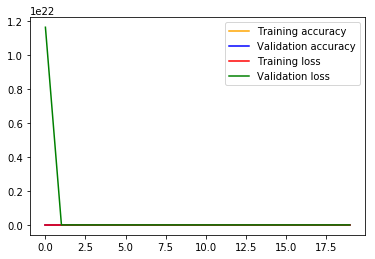

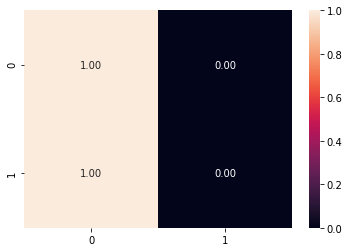

             precision    recall  f1-score   support

    Finding       0.50      1.00      0.67       250
     Normal       0.00      0.00      0.00       250

avg / total       0.25      0.50      0.33       500



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ValueError: too many values to unpack (expected 3)

In [26]:
incepv3(fold1_images,fold2_images,fold3_images,fold4_images,fold5_images,test_images,normal_images,"Intra")